# 10 Monkey Species

https://www.kaggle.com/slothkong/10-monkey-species?

Fine-grain classification with 10 species of monkeys.

## Load Data

In [1]:
import tensorflow as tf
from tensorflow import keras
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import os
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
data_dir = pathlib.Path('/notebooks/storage/kaggle-solutions/Kaggle-Solutions/data/10-monkey-species')
image_count = len(list(data_dir.glob('*/*/*/*.jpg')))
CLASS_NAMES = np.sort(np.array([item.name for item in data_dir.glob('training/training/*')]), axis=0)
CLASS_NAMES

array(['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9'],
      dtype='<U2')

In [3]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [4]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'training/training/*/*'))
for f in list_ds.take(5):
  print(f.numpy())

b'/notebooks/storage/kaggle-solutions/Kaggle-Solutions/data/10-monkey-species/training/training/n0/n0039.jpg'
b'/notebooks/storage/kaggle-solutions/Kaggle-Solutions/data/10-monkey-species/training/training/n1/n1149.jpg'
b'/notebooks/storage/kaggle-solutions/Kaggle-Solutions/data/10-monkey-species/training/training/n0/n0048.jpg'
b'/notebooks/storage/kaggle-solutions/Kaggle-Solutions/data/10-monkey-species/training/training/n9/n9147.jpg'
b'/notebooks/storage/kaggle-solutions/Kaggle-Solutions/data/10-monkey-species/training/training/n8/n8050.jpg'


In [5]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

get_label('/notebooks/storage/kaggle-solutions/Kaggle-Solutions/data/10-monkey-species/training/training/n7/n7054.jpg')

<tf.Tensor: id=103, shape=(10,), dtype=bool, numpy=
array([False, False, False, False, False, False, False,  True, False,
       False])>

In [6]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [7]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [8]:
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [9]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [ True False False False False False False False False False]


In [10]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [11]:
train_ds = prepare_for_training(labeled_ds)
image_batch, label_batch = next(iter(train_ds))

In [12]:
train_ds.batch(32)
train_ds.repeat()

<DatasetV1Adapter shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.bool)>

In [13]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

tf.Tensor([ True False False False False False False False False False], shape=(10,), dtype=bool)


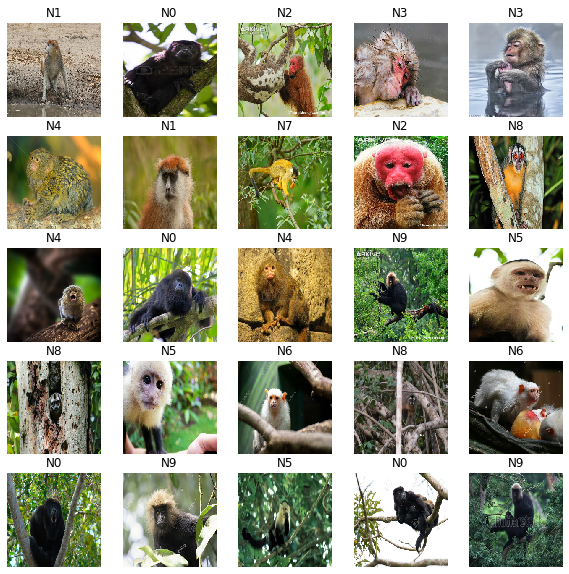

In [14]:
show_batch(image_batch.numpy(), label_batch.numpy())
print(label_batch[1])

## Create Model

Very basic model

In [15]:
model_v1 = keras.Sequential()
model_v1.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model_v1.add(keras.layers.MaxPooling2D((2, 2)))
model_v1.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model_v1.add(keras.layers.MaxPooling2D((2, 2)))
model_v1.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model_v1.add(keras.layers.Flatten())
model_v1.add(keras.layers.Dense(64, activation='relu'))
model_v1.add(keras.layers.Dense(10))
model_v1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 173056)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

## Train Model

In [16]:
model_v1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
model_v1.fit(train_ds, epochs=10, steps_per_epoch=STEPS_PER_EPOCH)

Train for 43.0 steps
Epoch 1/10
43/43 [==============================] - 2s 55ms/step - loss: 11.3272 - accuracy: 0.1512
Epoch 2/10
43/43 [==============================] - 2s 54ms/step - loss: 11.2218 - accuracy: 0.1548
Epoch 3/10
43/43 [==============================] - 2s 53ms/step - loss: 11.1046 - accuracy: 0.1526
Epoch 4/10
43/43 [==============================] - 2s 54ms/step - loss: 11.2569 - accuracy: 0.1490
Epoch 5/10
43/43 [==============================] - 2s 53ms/step - loss: 11.4092 - accuracy: 0.1519
Epoch 6/10
43/43 [==============================] - 2s 53ms/step - loss: 10.9758 - accuracy: 0.1548
Epoch 7/10
43/43 [==============================] - 2s 54ms/step - loss: 11.3272 - accuracy: 0.1526
Epoch 8/10
43/43 [==============================] - 2s 53ms/step - loss: 11.1749 - accuracy: 0.1475
Epoch 9/10
43/43 [==============================] - 2s 53ms/step - loss: 11.2100 - accuracy: 0.1541
Epoch 10/10
43/43 [==============================] - 2s 54ms/step - loss: 11.26